d:\work\python\forecast\.venv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


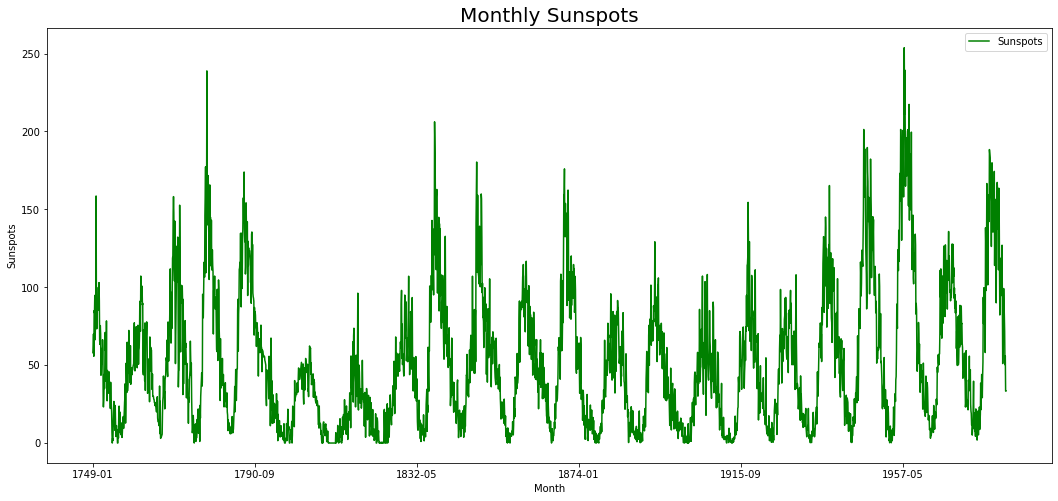

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import datetime

# nama file csv
file_csv = 'monthly-sunspots.csv'
# nama kolom untuk index (Month)
index_name = 'Month'
# nama kolom untuk data (Sales)
data_name = 'Sunspots'

df = pd.read_csv(file_csv, header=0, index_col=index_name)

def show_plot(df, title, color):
    df.plot(color=color, figsize=(18,8))
    plt.title(title, fontsize=20)
    plt.xlabel('Month')
    plt.ylabel('Sunspots')

show_plot(df, 'Monthly Sunspots', 'green')
plt.show()

# Preprocessing

In [38]:
from numpy import array
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


# 1. Sequencing/sampling

# split a univariate sequence into samples
# a = [3,4,1,2,3,5,7,8,9,1]
# n_step = 3
# a_seq = [
#   [3,4,1],
#   [4,1,2],
#   [1,2,3],
#   ...
#   [7,8,9]
# ]
# 
# a_res = [
#   [2],
#   [3],
#   [5],
#   ...
#   [1]
# ]

def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append([seq_y])
	return array(X), array(y)

n_steps = 3
all_x, all_y = split_sequence(df[data_name], n_steps)

# print("Sequence\n")
# print(all_x)

# print("\nResult\n")
# print(all_y)


# 2. normalisasi

# minmax_scaler dalam bentuk list ()
minmax_scaler = (0,1)
# data_scaler --> untuk data ke normalize
data_scaler = preprocessing.MinMaxScaler(minmax_scaler)
# target_scaler --> untuk normalize ke data (inverse)
target_scaler = preprocessing.MinMaxScaler()

all_x = data_scaler.fit_transform(all_x)
all_y = target_scaler.fit_transform(all_y)

# print(data_train)


# 3. data split

(train_x, test_x, train_y, test_y) = train_test_split(all_x, all_y, train_size=0.8, shuffle=False)

# print("TRAIN\n")
# print(train_x)
# print(train_y)

# print("\nTEST\n")
# print(test_x)
# print(test_y)

# Inisialisasi Network

In [39]:
from neupy import algorithms
from neupy.layers import *
from neupy.exceptions import StopTraining


# inisialisasi network
network = [
#     layer input
    Input(n_steps),
#     hidden layer
    Sigmoid(5),
#     layer output
    Sigmoid(1)
]

print(network)


# fungsi untuk cek tiap epoch
def on_epoch_end(optimizer):
  if optimizer.errors.train[-1] <= 0.0005:
    raise StopTraining("Training has been interrupted")

# deklarasi algoritma

# ann = algorithms.GradientDescent(
#     network=network,
#     shuffle_data=False,
#     show_epoch=100,
#     verbose=True,
#     signals=on_epoch_end
# )

# ann = algorithms.Momentum(
#     network=network,
#     shuffle_data=False,
#     show_epoch=100,
#     verbose=True,
#     signals=on_epoch_end
# )

# ann = algorithms.Hessian(
#     network=network,
#     shuffle_data=False,
#     show_epoch=100,
#     verbose=True,
#     signals=on_epoch_end
# )


# ann = algorithms.LevenbergMarquardt(
#     network=network,
# #     mu=0.1,
# #     mu_update_factor=1.1,
#     shuffle_data=False,
#     show_epoch=100,
#     verbose=True,
#     signals=on_epoch_end
# )

[Input(3, name='input-7'), Sigmoid(5, weight=HeNormal(gain=1.0), bias=Constant(0), name='sigmoid-13'), Sigmoid(1, weight=HeNormal(gain=1.0), bias=Constant(0), name='sigmoid-14')]

Main information

[ALGORITHM] LevenbergMarquardt

[OPTION] loss = mse
[OPTION] mu = 0.01
[OPTION] mu_update_factor = 1.2
[OPTION] show_epoch = 100
[OPTION] shuffle_data = False
[OPTION] signals = on_epoch_end
[OPTION] target = Tensor("placeholder/target/sigmoid-14:0", shape=(?, 1), dtype=float32)
[OPTION] verbose = True

[TENSORFLOW] Initializing Tensorflow variables and functions.
[TENSORFLOW] Initialization finished successfully. It took 2.63 seconds


# Training

In [40]:
ann.train(train_x, train_y, test_x, test_y, epochs=1000)

#1 : [1 sec] train: 0.221870, valid: 0.038952


#100 : [285 ms] train: 0.003637, valid: 0.009822


#200 : [221 ms] train: 0.003637, valid: 0.009822


#300 : [230 ms] train: 0.003637, valid: 0.009823


#400 : [324 ms] train: 0.003637, valid: 0.009824


#500 : [269 ms] train: 0.003637, valid: 0.009824


#600 : [265 ms] train: 0.003637, valid: 0.009825


#700 : [220 ms] train: 0.003637, valid: 0.009826


#800 : [228 ms] train: 0.003637, valid: 0.009826


#900 : [239 ms] train: 0.003637, valid: 0.009827


#1000 : [231 ms] train: 0.003637, valid: 0.009827


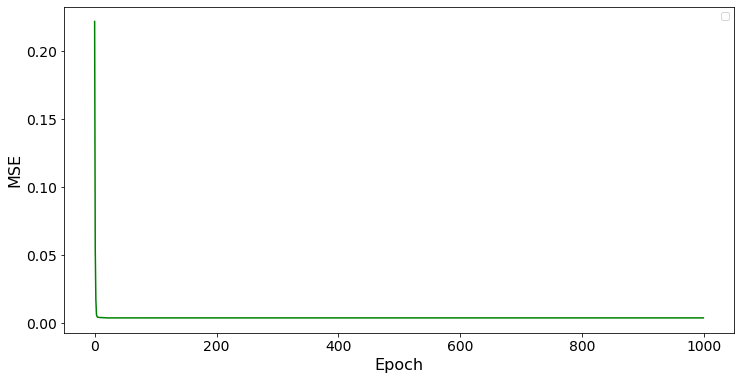

In [41]:
from pandas import DataFrame


df_error = DataFrame(ann.errors.train)

# line plot
df_error.plot(color='green', figsize=(12,6))

# set tick size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend('')

# set title & label
# plt.title(title, fontsize=20)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('MSE', fontsize=16)

plt.show()

# Prediksi

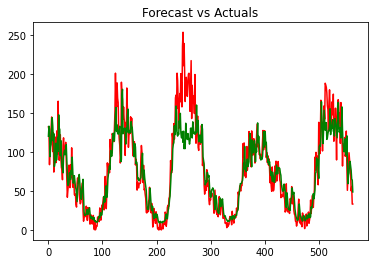

In [42]:
forecast_y = ann.predict(test_x)

test_y_inv = target_scaler.inverse_transform(test_y)
forecast_y_inv = target_scaler.inverse_transform(forecast_y)

plt.plot(test_y_inv, label="Actual", color="red")
plt.plot(forecast_y_inv, label="Forecast", color="green")
plt.title("Forecast vs Actuals")
plt.show()

# Evaluasi

In [43]:
import numpy as np

# rumus mape
def mape(y_true, y_pred): 
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

err_mape = mape(test_y_inv, forecast_y_inv)
print("MAPE: "+ str(err_mape))

MAPE: 72.34274636883576
